In [ ]:
!pip install transformers


In [ ]:
#install hugging face evaluate 
!pip install evaluate

In [3]:
# imports 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers import pipeline

#from datasets import load_dataset
from transformers import TrainingArguments, Trainer
from huggingface_hub import notebook_login
from textwrap import wrap


import evaluate


from sklearn.metrics import confusion_matrix, classification_report  


In [5]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
     

Mounted at /content/drive


In [6]:
# Read Data

# English Trainset
eng_trainset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_csv/train_seg.csv") 

# English Validationset
eng_valset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_csv/val_seg.csv") 

# German Testset 
eng_testset=pd.read_csv('/content/drive/MyDrive/IM/VTPAN_csv/VTPAN-test.csv')

In [39]:
eng_testset

,label,chatName,segment
0,1,de15188e9fd515ed817a0b34546be902,back ok babe what happend babe dog wanted out ...
1,0,17784c5a093477c1706b1a68cea7c802,hello boys are shit that they are hi sorry i w...
2,0,15a38614944f5aa8bbb59d4153ecc12a,"hi 19 m usa horny, u? 2+2*2 2+2*2? 6? yay now ..."
3,0,ee0aba2365c16a30cb36d1057a390b16,f/m ? hi there f u? hi m 18 nice ireland u ? u...
4,0,ca1b963746e368a4cec38ab4be3fdcf7,"sorry, I'm back now. and for the record I want..."
...,...,...,...
15324,0,85e044706ceca109b1adf6c744a4126c,Hello hello Hey... well this is awkward Really...
15325,1,ec391a65097a955029afaedc23d5fa81,hi asl? heya whats up? 13/f/socal whats ur asl...
15326,1,82add2c9da3c267a98b3981375b6c238,"good morning , how r u? hey :) im good u? am o..."
15327,0,e2bc24141a2855dd6825d8b3132bfa11,hi m or f hi f & u :) M :) frm? You ok ya im f...


In [8]:
#one-hot encoding the labels 
def to_sentiment(label):
  if label == 'predator':
    return 1
  elif label == 'non-predator':
    return 0

eng_testset['label'] = eng_testset['label'].apply(to_sentiment)

In [9]:
eng_testset

,label,chatName,segment
0,1,de15188e9fd515ed817a0b34546be902,back ok babe what happend babe dog wanted out ...
1,0,17784c5a093477c1706b1a68cea7c802,hello boys are shit that they are hi sorry i w...
2,0,15a38614944f5aa8bbb59d4153ecc12a,"hi 19 m usa horny, u? 2+2*2 2+2*2? 6? yay now ..."
3,0,ee0aba2365c16a30cb36d1057a390b16,f/m ? hi there f u? hi m 18 nice ireland u ? u...
4,0,ca1b963746e368a4cec38ab4be3fdcf7,"sorry, I'm back now. and for the record I want..."
...,...,...,...
15324,0,85e044706ceca109b1adf6c744a4126c,Hello hello Hey... well this is awkward Really...
15325,1,ec391a65097a955029afaedc23d5fa81,hi asl? heya whats up? 13/f/socal whats ur asl...
15326,1,82add2c9da3c267a98b3981375b6c238,"good morning , how r u? hey :) im good u? am o..."
15327,0,e2bc24141a2855dd6825d8b3132bfa11,hi m or f hi f & u :) M :) frm? You ok ya im f...


In [10]:
#tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base" )
model= AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base")

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [11]:
#data to list
X_train = list(eng_trainset["segment"])
y_train = list(eng_trainset["label"])
X_val = list(eng_valset["segment"])
y_val = list(eng_valset["label"])
X_test = list(eng_testset["segment"])
y_test = list(eng_testset["label"])
     

In [12]:
#tokenize 
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512)

In [13]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])
     

In [14]:
#load the 3 dataset
train_dataset = Dataset(train_encodings, y_train)
val_dataset = Dataset(val_encodings, y_val)
test_dataset = Dataset(test_encodings, y_test)

In [15]:
# Define Trainer
args = TrainingArguments(
    output_dir="xmlRob_En/En",
    num_train_epochs=3,
    per_device_train_batch_size=16

)
trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset)

In [16]:
#train
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.144500


TrainOutput(global_step=867, training_loss=0.11852380561168631, metrics={'train_runtime': 1361.3646, 'train_samples_per_second': 10.161, 'train_steps_per_second': 0.637, 'total_flos': 3639615228794880.0, 'train_loss': 0.11852380561168631, 'epoch': 3.0})

In [ ]:
notebook_login()


In [ ]:

#push model to hub
trainer.push_to_hub()

# **Test XML-Roberta on English Data**

In [20]:

#get prediction from test data 
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
     

In [46]:

# macro f1 on test data 
metric = evaluate.load("f1")
metric.compute(predictions=preds, references=y_test,  average="macro")
     

{'f1': 0.9823067136891728}

In [47]:
class_names = [ '0', '1']
     

In [28]:
#classification report

print(classification_report(y_test, preds, target_names=class_names))

              precision    recall  f1-score   support

non predator       1.00      0.99      1.00     13863
    predator       0.94      0.97      0.96      1466

    accuracy                           0.99     15329
   macro avg       0.97      0.98      0.98     15329
weighted avg       0.99      0.99      0.99     15329



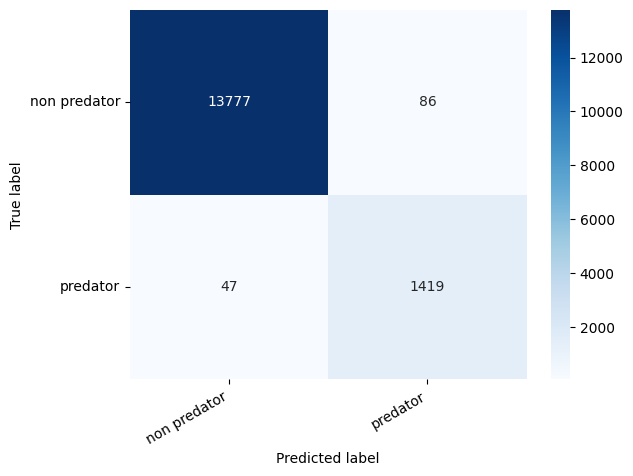

In [29]:

#confusion matrix 
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
     

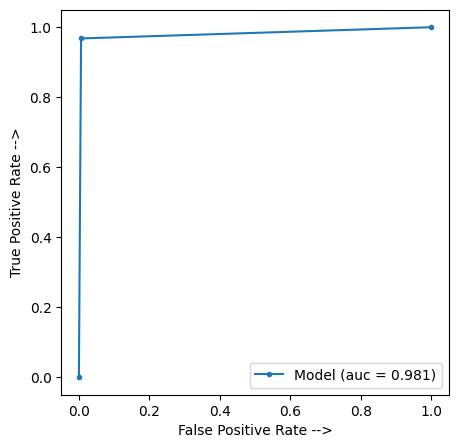

In [30]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, preds)
auc = auc(fpr, tpr)

#svm_fpr, svm_tpr, threshold = roc_curve(y_test, y_pred_svm)
#auc_svm = auc(svm_fpr, svm_tpr)

plt.figure(figsize=(5, 5), dpi=100)
#plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (auc = %0.3f)' % auc_svm)
plt.plot(fpr, tpr, marker='.', label='Model (auc = %0.3f)' % auc)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [34]:

#missclassified examples 
misclassified = np.where(preds != y_test)
print(misclassified)

(array([   30,   157,   729,   970,   983,  1051,  1074,  1081,  1150,
        1723,  1801,  1853,  1969,  2005,  2298,  2389,  2472,  2507,
        2943,  3013,  3036,  3380,  3434,  3548,  4098,  4429,  4468,
        4515,  4556,  4660,  5062,  5291,  5352,  5371,  5434,  5633,
        5666,  5762,  5956,  6561,  6599,  7015,  7080,  7381,  7462,
        7507,  7533,  7600,  7621,  7622,  7629,  7668,  7680,  7877,
        7881,  8634,  9080,  9756,  9902, 10265, 10381, 10490, 10649,
       10719, 10932, 10945, 10953, 11095, 11108, 11201, 11446, 11972,
       12192, 12263, 12427, 12462, 12886, 12933, 13022, 13137, 13261,
       13382, 13467, 13886, 13933, 14000, 14158, 14673, 14704, 14835,
       14874, 14876, 15103]),)


In [49]:
len(preds)

15329

In [48]:
#from transformers import pipeline

#Test on raw text 
text = ['Hi , hi, are he still mad at you? no, but he wont let me go to school, my unlce. why dont you come visist me when your parents away?what city are you from? will tell you anothzer time. why not today?becasue you are much older. Iam 13 and you are 40. whats the rpoblem?']
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)
pipe(text)

[{'label': 'LABEL_0', 'score': 0.9935779571533203}]